In [16]:
import numpy as np
import scipy.stats
import pandas as pd
import keras.backend as K
from vae import create_vae, restore_model
import tensorflow as tf
from vaeArgs import *

/usr/lib/python3/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
sess.close()

In [17]:
# Avoid GPU for memory issues (so I can do analysis while GPU is training elsewhere)
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True,
                                                   device_count={'GPU': 0}))

In [187]:
#args, vae = restore_model('models/L0.0000100-D200000_1200_800_200-b256-N85000-E1000-l1000.0-a1.0-v202498-kMMD-idf-keras-full.h5')
args, vae = restore_model('data/literature/models/L0.0000500-D10000_2000_50-b256-N5000-E500-l1-a0-v202498-kELBO-idf-keras-full.h5')
encoder = vae.get_layer('encoder')
decoder = vae.get_layer('decoder')
latent_n = encoder.get_layer('z').output_shape[1]

In [188]:
trim_head = 200
token_ref = pd.read_csv('eng-vocab-1.txt.bz2', names=['token'])[trim_head:].reset_index(drop=True)
idf = np.load('idf-1.npy')[trim_head:]

# Using the generator to inspect the latent dimensions (akin to topics)

In [189]:
def ae_moments(decoder):
    '''
    Generate fake documents evenly distributed across the latent space, then
    return the generated documents with their mean and stddev
    '''
    latent_n = decoder.get_layer('DecoderInput').input_shape[1]
    ones = np.zeros((latent_n,latent_n))
    np.fill_diagonal(ones, np.ones(latent_n))
    reconstructed = decoder.predict(ones)
    _std, _mean = reconstructed.std(axis=0), reconstructed.mean(axis=0)
    return reconstructed, _std, _mean

In [203]:
generated, _std, _mean = ae_moments(decoder)
ztopics = (generated - _mean) / _std

vocab_lim = 200000 # Only inspect words at index vocab_lim and above

labels = dict()

for i in range(0,ztopics.shape[0]):
    ind = pd.Series(ztopics[i]).sort_values().index
    ind = ind[ind < vocab_lim]
    labels["%d-" % i] = ", ".join(token_ref.iloc[ind[-10:]][::-1]['token'].tolist())
    labels["%d+" % i] = ", ".join(token_ref.iloc[ind[:10]]['token'].tolist())
    print("%d-: %s" % (i, ", ".join(token_ref.iloc[ind[-10:]][::-1]['token'].tolist())))
    print("%d+: %s" % (i, ", ".join(token_ref.iloc[ind[:10]]['token'].tolist())))

0-: everyone, laughed, music, laughing, dare, laugh, hall, students, soldiers, revolution
0+: islands, miles, rock, luck, coast, mile, trunk, island, bay, pacific
1-: sam, sit, chair, come, table, friend, lord, george, simon, aaron
1+: yards, japanese, bull, spot, girl, violet, ceremony, dawn, spencer, eighteen
2-: carriage, delight, lovely, conversation, delightful, joy, fond, ladies, manners, soon
2+: tim, murder, bloody, killed, lying, murphy, kill, does, data, giant
3-: police, constable, oliver, sergeant, office, inspector, club, clients, julia, bus
3+: rose, feet, lay, does, brother, wind, foot, trees, leaves, why
4-: morning, driver, picked, pocket, next, crew, night, george, rain, cards
4+: paintings, ancestors, ghost, wanting, subtle, slave, picture, grace, existence, understanding
5-: bird, feathers, birds, wings, wi, an', fur, ye, season, set
5+: understand, students, n't, guilty, something, murder, believe, front, stopped, press
6-: wanted, information, according, question,

## Generating imaginary documents

In [172]:
# See what the dimensions are about
doc = np.zeros((1,latent_n))
doc[0, []] = 1
doc[0, [188]] = -1
expanded = decoder.predict(doc)[0]
ztopics = (expanded-_mean)/_std

ind = pd.Series(ztopics).sort_values().index
ind = ind[ind < vocab_lim]
print("%s" % (", ".join(token_ref.iloc[ind[:100]]['token'].tolist())))

citizen, persistent, perhaps, skins, mile, oriental, receiver, board, ma, neighbor, ta, screen, belonged, exhausted, brand, frederick, injured, gordon, wire, disappointed, marie, piano, wife, rue, neat, tries, abuse, phillips, opera, macmillan, adds, article, finding, disorders, eaten, despite, potatoes, 79, preaching, shapes, authorities, district, julia, immediately, canyon, matthew, shortly, vigorous, weeds, bars, speakers, spot, prolonged, puts, crude, hire, interesting, closing, steam, lasting, brain, machines, surface, heaven, heat, lamb, genuine, describing, discretion, brought, paying, pierce, dish, tasks, weigh, barley, crime, depended, cave, fractions, applicable, opposite, riding, turkey, newspapers, plea, baltimore, thorough, apparent, earl, der, eugene, network, id, client, maintaining, circles, interpreted, linen, farther


## Generating latent codes for words

Focusing on top 5k words.

In [191]:
indim = encoder.get_layer('input_1').input_shape[1]
indocs = np.zeros((5000,indim))
np.fill_diagonal(indocs, idf[:5000])
encoded = encoder.predict(indocs)

ValueError: No such layer: input_1

In [31]:
np.savetxt("export/worddata.csv", encoded, delimiter="\t")
token_ref[:5000].to_csv('export/wordmeta.csv', sep='\t', header=False, index=False)

## Getting topics about a document

In [1]:
import pandas as pd

In [56]:
meta = pd.read_csv('data/literature/ficmeta.csv')

/home/organisciak_gmail_com/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [143]:
meta[meta.author.fillna('').str.contains('Tolkie') & meta.title.str.contains('ellowship')][['docid', 'title']]

,docid,title
62931,mdp.49015002568781,The fellowship of the ring : | Being the first...
76058,uc1.32106015420547,The fellowship of the ring : | being the first...


In [174]:
from htrc_features import FeatureReader, utils
# 1984, Brave New World, Fellowship of the Ring
utils.download_file(['mdp.39015060000752', 'mdp.39015002231440', 'mdp.49015002568781'])
fr = FeatureReader(['mdp.39015060000752.json.bz2', 'mdp.39015002231440.json.bz2', 'mdp.49015002568781.json.bz2'])

In [192]:
def vol2vec(vol, idf=idf):
    tl = (vol.tokenlist(pos=False, case=False).reset_index()[['lowercase', 'count']]
             .rename(columns={'lowercase':'token'})
             .groupby('token', as_index=False)[['count']].sum()
         )
    counts = pd.merge(tl, token_ref[:args.dims[0]].reset_index())[['index', 'count']].sort_values('index')
    #counts = counts[(counts['index'] < args.dims[0]+200) & (counts['index'] > 200)]

    doc = np.zeros((1,args.dims[0]))
    doc[0, counts['index'].values] = counts['count'].values
    doc = doc * idf[:args.dims[0]]
    return doc

docs = np.vstack([vol2vec(vol) for vol in fr.volumes()])
ldocs = encoder.predict(docs)

docs.shape, ldocs.shape

((3, 10000), (3, 50))

In [198]:
ldocprobs = (ldocs.T/ldocs.sum(axis=1)).T
pd.Series(ldocprobs[2] - ldocprobs[0]).sort_values(ascending=False).head(10)

23    0.234187
8     0.144453
17    0.139016
2     0.133799
35    0.128047
27    0.127119
20    0.113219
22    0.109049
24    0.105485
5     0.103404
dtype: float32

In [199]:
labels['23+']

'lose, hate, prisoners, friends, insane, orders, happen, madam, arrest, rage'

In [200]:
ztopics = (decoder.predict(ldocs) - _mean) / _std
compare = pd.Series(ztopics[2] - ztopics[0]).sort_values(ascending=False)
print("%s" % (", ".join(token_ref.iloc[compare.index[:100]]['token'].tolist())))

easy, lead, carrying, carry, settled, drawing, breaking, fresh, ways, busy, spread, finding, follow, setting, drop, lower, hoped, calling, safe, gathering, keen, curious, leading, gather, somewhat, approach, driven, slow, gentle, anywhere, meet, nowhere, reply, settle, joined, ours, escaped, filling, gathered, field, pointing, disturbed, stopping, kindly, rapidly, urged, hang, anxious, easier, seeking, ease, peaceful, loose, rising, main, wasted, casting, finished, sharply, early, reaching, june, quarter, hide, spirits, lie, steadily, wandering, broad, directions, fair, nearest, chance, dozen, idle, pleased, post, planted, join, dry, travel, fancy, bold, direction, harm, wider, meantime, plainly, approaching, rested, stirred, splendid, guide, sought, pleasant, approached, earnest, distant, peace, wise


In [201]:
ztopics = (decoder.predict(ldocs) - _mean) / _std
ind = pd.Series(ztopics[0]).sort_values().index
ind = ind[ind < vocab_lim]
print("%s" % (", ".join(token_ref.iloc[ind[:100]]['token'].tolist())))

bringing, easy, lack, suggested, due, lead, added, carrying, settled, fresh, carry, prepared, busy, unless, spread, share, ways, explained, drawing, offered, private, follow, hoped, breaking, needs, setting, showing, finding, safe, chose, proper, chosen, lower, calling, choice, drop, heavily, saved, considered, expect, earlier, avoid, helped, firmly, refused, leading, allow, continue, keen, meet, slow, rule, paid, gathering, assured, curious, arranged, agreed, raise, somewhat, gentle, add, paying, plan, accepted, early, comment, fourth, reply, elsewhere, various, relief, properly, cutting, recently, approach, driven, throwing, works, satisfaction, offering, shortly, fill, repeated, returning, field, happily, business, score, rules, main, determined, exercise, pronounced, admitted, anywhere, announced, practically, placed, useful


In [205]:
df = pd.DataFrame(ldocs[0], columns=['weight'])
df['abs_weight'] = df.weight.abs()
df['sign'] = df.weight.apply(lambda x: "+" if x >= 0 else "-")
df = df.reset_index().rename(columns={'index':'dim'})
df = df.sort_values('abs_weight', ascending=False)
df['terms'] = (df.dim.astype('str') + df.sign).apply(lambda x: labels[x])
df.head()

,dim,weight,abs_weight,sign,terms
48,48,694.156433,694.156433,+,"tired, sometimes, suppose, liked, summer, libr..."
10,10,610.782410,610.782410,+,"question, party, member, parties, allen, acqua..."
39,39,592.815613,592.815613,+,"alan, ass, spanish, keep, looks, carl, bad, de..."
28,28,510.468964,510.468964,+,"apartment, night, window, came, hung, red, wen..."
31,31,-491.142822,491.142822,-,"k, v, w, theorem, receiver, u, catherine, r, c..."


In [206]:
df.tail()

,dim,weight,abs_weight,sign,terms
43,43,53.296806,53.296806,+,"roof, boots, clothes, night, heavy, tomorrow, ..."
22,22,27.277739,27.277739,+,"tu, moses, sisters, flour, silk, marie, japane..."
16,16,26.268019,26.268019,+,"planet, game, space, play, computer, onto, hum..."
23,23,-23.351639,23.351639,-,"moved, alice, norman, david, edward, handed, l..."
2,2,9.011530,9.011530,+,"tim, murder, bloody, killed, lying, murphy, ki..."


In [207]:
fakedoc = ldocs[2] - ldocs[0]
ztopics = (decoder.predict(fakedoc.reshape(1, 200)) - _mean) / _std
compare = pd.Series(ztopics[0]).sort_values(ascending=False)
print("%s" % (", ".join(token_ref.iloc[compare.index[:100]]['token'].tolist())))

ValueError: cannot reshape array of size 50 into shape (1,200)

In [208]:
for i, row in df.head(20).iterrows():
    vocab_lim = 10000 # Only inspect words at index vocab_lim and above

    ind = pd.Series(ztopics[row['dim']]).sort_values().index
    if row['sign'] == '-':
        ind = ind[::-1]
    ind = ind[ind < vocab_lim]
    print("%d%s: %s" % (row['dim'], row['sign'], ", ".join(token_ref.iloc[ind[:10]]['token'].tolist())))

48+: tired, sometimes, suppose, liked, summer, library, supper, books, mrs., mary
10+: question, party, member, parties, allen, acquainted, county, ask, answer, thompson
39+: alan, ass, spanish, keep, looks, carl, bad, denmark, stuff, shakespeare
28+: apartment, night, window, came, hung, red, went, walked, sue, room
31-: k, v, w, theorem, receiver, u, catherine, r, cable, corresponds
44-: daughter, mother, aunt, sister, child, family, father, marriage, married, husband
0+: islands, miles, rock, luck, coast, mile, trunk, island, bay, pacific
47-: cold, winter, printed, smoke, dan, tobacco, ltd, canada, printing, copyright
49-: rope, cabin, yard, running, rail, onto, joe, wet, ray, barn
25+: seat, happy, smiling, smiled, laura, put, looked, smile, drove, everyone
4-: morning, driver, picked, pocket, next, crew, night, george, rain, cards
21-: rue, inc., copyright, don, publisher, income, ltd, edition, rent, reserved
8+: navy, background, edward, routine, henry, america, morgan, press, j

In [165]:
expanded = decoder.predict(ldoc)[0]
z = (expanded - means) / stddev

ind = pd.Series(z).sort_values().index
ind = ind[ind < vocab_lim]
print("%s" % (", ".join(token_ref.iloc[ind[:100]]['token'].tolist())))

courtesy, unknown, supplied, permission, contents, transferred, source, converted, fitting, distributed, plot, modified, arrangements, counter, combined, collecting, remote, complete, introduced, collect, replaced, ,1, minor, representing, prompt, regarding, preparing, newly, refers, specially, obtaining, counting, retained, confirmed, examining, '', maintained, concerning, grounds, aid, enclosed, hi, confirm, demonstration, consisting, transmitted, brief, expanded, rank, recommended, adding, preference, io, returns, 5000, introducing, fill, uniform, originally, checked, pan, promising, transmit, addition, temporary, suitable, trace, *', planned, exclusive, replace, successfully, details, highly, conjunction, tne, contributed, designated, convert, separation, reserved, exclusively, ninth, inter, supplying, reliable, em, chambers, excluding, investigate, prepare, included, absence, consisted, prepared, fitted, formerly, affecting, 'a, ment


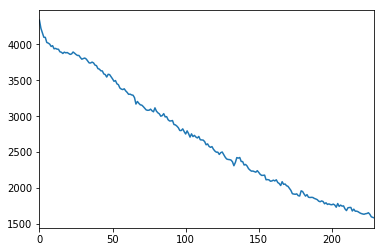

In [35]:
import json
%matplotlib inline
with open('logs/L0.0000100-H2100-G1000-b512-l200-N24000-E100-v202498-t100000-oAdam-SCross-entropy-idf-log.json', mode='r') as f:
    lines = f.read().split('\n')
last_log = json.loads(lines[-1])
pd.Series(last_log['history']['val_loss'][10:]).plot()